# Simple Object Detection using Python
**Author**: Johannes S. Fischer

In [1]:
save_figures = True

In the past days I worked myself into object detection with neural networks. For simplicity, I decided to start with a simple task: detect a bounding box of one single rectangle on a neutral background. This has the advantages that I can generate the data set myself and the images are not too complex. Let's start!

## The Task

The network gets as input a $n \times n$ image with black background and a green rectangle and will predict the target vector $(x, y, w, h)$, where x and y denote the top-left corner of the rectangle and $w$ and $h$ are the width and height of it, respectively. This is further illustrated in the following image, with $n=8$:

(2, 2, 3, 3)


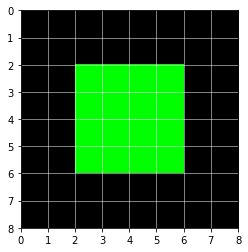

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

n = 8

x = 2
y = 2
w = 3
h = 3

img = np.zeros((n, n, 3), dtype="uint8")
cv2.rectangle(img, (x,y), (x+w,y+h), (0, 255, 0), -1)
plt.imshow(img, interpolation="nearest")
ax = plt.gca()
ax.set_xticks(np.arange(-.5, n, 1))
ax.set_yticks(np.arange(-.5, n, 1))
ax.set_xticklabels(np.arange(0, n+1, 1))
ax.set_yticklabels(np.arange(0, n+1, 1))
ax.grid(color='white', linestyle='-', linewidth=0.5)
print((x, y, w, h))

if save_figures:
    plt.savefig('example-image1.png', dpi=300, bbox_inches='tight')
plt.show()

## Create Data
With an image size of 8 the possibilities for a rectangle would be quite limited. Therefore, I decided to set the size to 64, which easily allows to draw 40.000 samples. The minimum size for the rectangle is set to 8. I will use standard libraries, such as numpy, pyplot, and OpenCV.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# dataset settings
n_samples = 40000
image_size = 64
min_size = 8

The images will be stored in a numpy array $X$ with the dimensions (40000, 64, 64, 3), where 40.000 refers to the number of images, 64 to the image width and height, and 3 to the number of color channels (RGB). The target vector for one image has four elements (x, y, width, height). Thus, $Y$ has the dimensions (40000, 4).

In [4]:
X = np.zeros((n_samples, image_size, image_size, 3), dtype="uint8")
Y = np.zeros((n_samples, 4))

The creation of the images works as follows:

In [5]:
for sample in range(n_samples):
    # create image
    img = np.zeros((image_size, image_size, 3), dtype="uint8")
    
    # get random x and y coordinate
    x = np.random.randint(0, image_size - min_size)
    y = np.random.randint(0, image_size - min_size)
    
    # get random width and height
    w = np.random.randint(min_size, image_size - x)
    h = np.random.randint(min_size, image_size - y)

    # assign target vector to sample
    Y[sample] = [x, y, w, h]

    # draw rectangle on image
    cv2.rectangle(img, (x,y), (x+w,y+h), (0, 255, 0), -1)
    X[sample] = img

To inspect what we've done so far, lets plot the first 10 images:

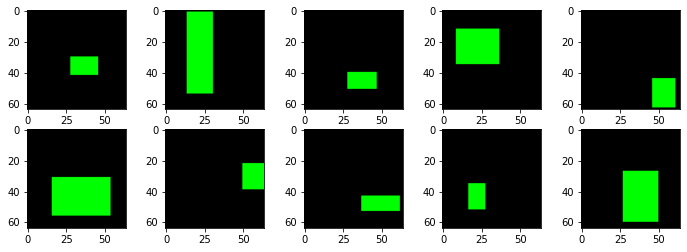

In [6]:
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i])

if save_figures:
    plt.savefig('blog images/first-10-1.png', dpi=300, bbox_inches='tight')
plt.show()

## Prepare Data
First of all, I will normalize the input data to be centered around 0. The RGB values are within 0 and 255. Hence, I can just divide the feature tensor by 255, so that all values are within 0 to 1 and can then subtract 0.5, to center the values.

In [7]:
# normalize images
X = X.astype("float32") / 255
# center pixel values
X = X - 0.5

Furthermore, I split the data into a training, validation, and test set, using sklearn's train_test_split function.

In [8]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2)

# further split train_val
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=29)

print("Shape X train:\t  ", X_train.shape)
print("Shape X validate: ", X_val.shape)
print("Shape X test:\t  ", X_test.shape)

Shape X train:	   (25600, 64, 64, 3)
Shape X validate:  (6400, 64, 64, 3)
Shape X test:	   (8000, 64, 64, 3)


## Convolutional Neural Network
Now it's time to build the model that can predict the four parameters for each image describing the rectangle $(x, y, w, h)$. I use the Keras Sequential class as I will only use a linear stack of layers.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense
from tensorflow.keras.layers import Flatten, Dropout

model = Sequential([
    Conv2D( 32, kernel_size=3, activation="relu",
           input_shape=(image_size, image_size, 3)),
    MaxPooling2D( pool_size=2),
    Conv2D( 32, kernel_size=3, activation="relu"),
    MaxPooling2D( pool_size=2),
    Flatten(),
    Dropout(0.5),
    Dense(4)
])

model.compile("adam", loss="mse", metrics=["accuracy"])

The model is kept simple, with two blocks consisting of a convolutional layer, followed by a max pooling layer. Finally, the input is flattened and connected to a dense layer with 4 nodes, which represent the target vector (x, y, w, h).

I use Adam as Optimizer and as loss the mean squared error, as the target is rather continuous.

Time to start the training!

In [10]:
%%time
epochs = 18
history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    validation_data=(X_val, Y_val))

Epoch 1/18
800/800 [==============================] - 13s 10ms/step - loss: 75.7384 - accuracy: 0.7206 - val_loss: 18.0553 - val_accuracy: 0.8967
Epoch 2/18
800/800 [==============================] - 8s 10ms/step - loss: 15.2114 - accuracy: 0.8996 - val_loss: 5.8563 - val_accuracy: 0.9489
Epoch 3/18
800/800 [==============================] - 7s 9ms/step - loss: 9.7855 - accuracy: 0.9205 - val_loss: 3.9868 - val_accuracy: 0.9523
Epoch 4/18
800/800 [==============================] - 8s 9ms/step - loss: 8.1445 - accuracy: 0.9315 - val_loss: 3.6387 - val_accuracy: 0.9605
Epoch 5/18
800/800 [==============================] - 7s 9ms/step - loss: 7.1980 - accuracy: 0.9343 - val_loss: 3.1780 - val_accuracy: 0.9627
Epoch 6/18
800/800 [==============================] - 8s 9ms/step - loss: 6.6886 - accuracy: 0.9368 - val_loss: 2.8331 - val_accuracy: 0.9631
Epoch 7/18
800/800 [==============================] - 7s 9ms/step - loss: 6.0726 - accuracy: 0.9416 - val_loss: 2.3337 - val_accuracy: 0.9600


With my setup (GPU: Nvidia GeForce GTX 1050 Ti, CPU: Intel i5-3470) the training takes about 2 minutes and 26 seconds.

## Results
When plotting the history of the training process I get the following results:

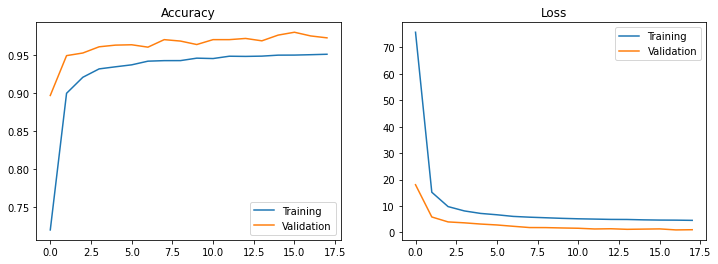

In [11]:
plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(np.arange(epochs), history.history['accuracy'], label='Training')
plt.plot(np.arange(epochs), history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(np.arange(epochs), history.history['loss'], label='Training')
plt.plot(np.arange(epochs), history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()

if save_figures:
    plt.savefig('blog images/training-validation-1.png', dpi=300,
                bbox_inches='tight')
    
plt.show()

Let's evaluate the model on (unseen) test data.

In [12]:
loss, acc = model.evaluate(X_test, Y_test)
print("Accuracy: %.4f"%acc)
print("Loss: %.4f"%loss)

250/250 [==============================] - 1s 4ms/step - loss: 1.0525 - accuracy: 0.9772
Accuracy: 0.9772
Loss: 1.0525


An accuracy of about 97% seems quite good for such a simple model. However, accuracy itself may not be an appropriate indicator of how well the bounding boxes are predicted. So let's consider another measure, namely the Intersection over Union (IoU).

In short: The Intersection over Union measures the overlap between two bounding boxes. A value of 1 indicates perfect prediction, while lower values suggest a poor accuracy.

For a more intuitive understanding let's have a look at an example. In the picture below two rectangles A (green) and B (blue) are displayed. A has a width and height of 7 and starts at (3, 3), while B has a width and height of 6 and starts at (7, 7).

In [13]:
def computeIoU(bbox1, bbox2):
    (x1, y1, w1, h1) = bbox1
    (x2, y2, w2, h2) = bbox2
    
    # area of both rectangles
    area1 = (w1+1) * (h1+1)
    area2 = (w2+1) * (h2+1)
    
    # intersection rectangle coordinates
    inter_x1 = np.max((x1, x2))
    inter_y1 = np.max((y1, y2))
    inter_x2 = np.min((x1 + w1, x2 + w2))
    inter_y2 = np.min((y1 + h1, y2 + h2))
    
    # intersection rectangle width and height
    inter_w = np.max( (0, inter_x2 - inter_x1 +1) )
    inter_h = np.max( (0, inter_y2 - inter_y1 +1) )
        
    if inter_w <= 0 or inter_h <= 0:
        return 0.0
    
    # intersection area
    inter_area = inter_w * inter_h
    
    # return iou
    return inter_area / float(area1 + area2 - inter_area)

IoU: 0.1184


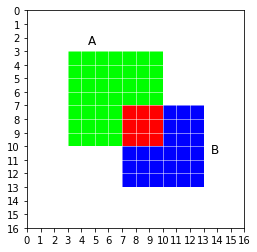

In [14]:
field_size = 16

img = np.ones((field_size, field_size, 3), dtype="uint8") * 255

# rect 1
x1, y1, w1, h1 = 3, 3, 6, 6
cv2.rectangle(img, (x1,y1), (x1+w1,y1+h1), (0, 255, 0), -1)
# rect 2
x2, y2, w2, h2 = 7, 7, 5, 5
cv2.rectangle(img, (x2,y2), (x2+w2,y2+h2), (0, 0, 255), -1)
# intersection
x3, y3, w3, h3 = 7, 7, 2, 2
cv2.rectangle(img, (x3,y3), (x3+w3,y3+h3), (255, 0, 0), -1)

# show image
plt.imshow(img, interpolation="nearest")

# annotate
plt.annotate("A", (4, 2), color="black", size="large")
plt.annotate("B", (13, 10), color="black", size="large")
ax = plt.gca()
ax.set_xticks(np.arange(-.5, field_size, 1))
ax.set_yticks(np.arange(-.5, field_size, 1))
ax.set_xticklabels(np.arange(0, field_size+1, 1))
ax.set_yticklabels(np.arange(0, field_size+1, 1))
ax.grid(color='white', linestyle='-', linewidth=0.5)

# compute iou
IoU_example = computeIoU((x1, y1, w1, h1), (x2, y2, w2, h2))
print("IoU: %.4f"%IoU_example)

if save_figures:
    plt.savefig('blog images/iou-example.png', dpi=300,
                bbox_inches='tight')
plt.show()

The IoU can now be described as the area of overlap divided by the area of the union. So: $IoU = \frac{A \cap B}{A \cup B}$

For our concrete example the intersecting area is $3 \cdot 3 = 9$, the green area is $7 \cdot 7 = 49$ and the blue area is $6 \cdot 6 = 36$. The union of A and B is $49 + 36 - 9 = 76$ (area A + area B - intersection). Now we can compute the Intersection over Union by dividing the intersection through the union and we get an IoU of $9 / 76 = 0.1184$.

In [15]:
# predict test set
preds = model.predict(X_test)

# compute mean IoU
iou_all = []
for i in range(len(Y_test)):
    iou_all.append(computeIoU(Y_test[i], preds[i]))
print("Mean IoU over Test Set: %.4f"%(np.mean(iou_all)))

Mean IoU over Test Set: 0.8293


Plot the first 10 predicted samples.

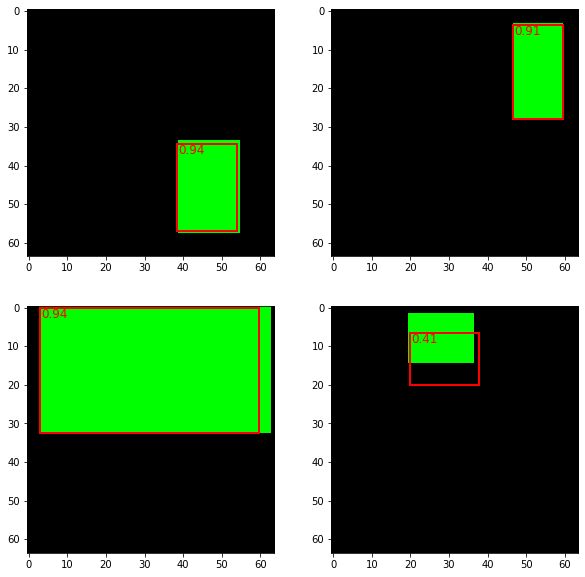

In [16]:
import matplotlib.patches as patches

# return X to its normal values
X_test_plot = X_test + 0.5
X_test_plot = X_test_plot * 255
X_test_plot = X_test_plot.astype("uint8")

# subplots
plt.figure(figsize=(10, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    # plot truth
    ax.imshow(X_test_plot[i])
    # plot estimate
    rect = patches.Rectangle((preds[i, 0], preds[i, 1]), preds[i, 2], preds[i, 3],
                             linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect)
    # annotate with iou
    plt.annotate("%.2f"%(computeIoU(preds[i], Y_test[i])),
                 (preds[i, 0]+0.3, preds[i, 1]+2.6),
                 color="red", size="large")
    
if save_figures:
    plt.savefig('blog images/sample-detections-1.png', dpi=300,
                bbox_inches='tight')
plt.show()

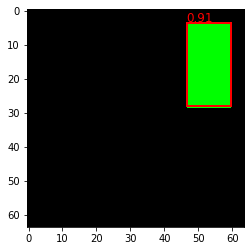

MSE:	0.3546
IoU:	0.9107
Estimate:	 [46.63  3.62 13.02 24.31]
Truth:		 [47.  4. 12. 24.]


In [17]:
i = 1

# Plotting
fig, ax = plt.subplots()
ax.imshow(X_test_plot[i])
# add prediction
rect = patches.Rectangle((preds[i, 0], preds[i, 1]), preds[i, 2], preds[i, 3],
                         linewidth=2, edgecolor="r", facecolor='none')
ax.add_patch(rect)
IoU = computeIoU(preds[i], Y_test[i])
plt.annotate("%.2f"%(IoU),
             (preds[i, 0]-0.3, preds[i, 1]-0.5),
             color="red", size="large")
plt.show()

import tensorflow as tf
mse = float(tf.keras.metrics.mean_squared_error(preds[i], Y_test[i]))
print("MSE:\t%.4f"%mse)
print("IoU:\t%.4f"%IoU)
print("Estimate:\t", np.round(preds[i], 2))
print("Truth:\t\t", Y_test[i])

---